# 0. Imports and Plot Formatting <a name="imports"></a>

In [22]:
# IMPORTS

import os
import sys
sys.path.append("../../")

%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import rc
from scipy.interpolate import interp1d
from scipy.integrate import *

import dill as pickle

from axion_kSZ_source.axion_camb_wrappers.run_axion_camb import AxionCAMBWrapper
from axion_kSZ_source.theory.cosmology import Cosmology,CosmologyCustomH
from axion_kSZ_source.theory.sigma_interpolation import SigmaInterpolator
from axion_kSZ_source.theory.sigma_interpolation_FFTLog import SigmaInterpolatorFFTLog
from axion_kSZ_source.auxiliary.integration_helper import IntegrationHelper
from axion_kSZ_source.auxiliary.window_functions import WindowFunctions
from axion_kSZ_source.theory.eli_mass_functions import EliMassFunction
from axion_kSZ_source.theory.eli_mass_functions import BubbleMassFunction
from axion_kSZ_source.theory.eli_mass_functions import BMF2
from axion_kSZ_source.theory.halo_bias_new import HaloBias
from axion_kSZ_source.theory.correlation_functions import CorrelationFunctions
from axion_kSZ_source.theory.correlation_functions_FFTLog import CorrelationFunctions as CorrelationFunctionsFFTLog

# PLOT FORMATTING

plt.rc('font',**{'family':'serif','serif':['Palatino']})
plt.rc('text', usetex=True)
#plt.mathtext.rcParams['legend.fontsize']='medium'
plt.rcParams["figure.figsize"] = [8.0,6.0]
axislabelfontsize='large'
matplotlib.mathtext.rcParams['legend.fontsize']='medium'


matplotlib.rcParams['font.family'] = 'Times New Roman'

rc("axes", linewidth=2.0)
rc("lines", markeredgewidth=4)
rc('xtick', labelsize = 20)
rc('ytick', labelsize = 20)

fig_width_pt = 703.27 #513.17           # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inches
golden_mean=0.9
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height =fig_width*golden_mean       # height in inches
fig_size = [fig_width,fig_height]
#
params = {'backend': 'pdf',
             'axes.labelsize': 14,
             'lines.markersize': 4,
             'font.size': 14,
             'xtick.major.size':6,
             'xtick.minor.size':3,
             'ytick.major.size':6,
             'ytick.minor.size':3,
             'xtick.major.width':0.5,
             'ytick.major.width':0.5,
             'xtick.minor.width':0.5,
             'ytick.minor.width':0.5,
             'lines.markeredgewidth':1,
             'axes.linewidth':1.2,
             'xtick.labelsize': 14,
             'ytick.labelsize': 14,
             'savefig.dpi':2000,
   #      'path.simplify':True,
   #      'font.family': 'serif',
   #      'font.serif':'Times',
             'text.usetex':True,
             'text.latex.preamble': [r'\usepackage{amsmath}'],
             'figure.figsize': fig_size}

plt.rcParams.update(params)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Table of Contents
1. [Imports and Plot Formatting](#imports)
1. [Cosmology](#cosmo)
    1. [Cosmology Functions](#cosmo_functions)
    1. [Cosmologies](#cosmologies)
1. [Plots and Bubble Work](#plots)
1. [Testing, Scratch, and Junk](#test)

# 1. Cosmology <a name="cosmo"></a>

Everything that is evaluated for a certain cosmology is stored in the various arrays below, and anytime a cosmology is updated or added, the changes to the arrays should be computed automatically, so they can be called easily and consistently at any time

### A. Cosmology functions<a name="cosmo_functions"></a>

##### Run this cell before doing any cosmology stuff!
Functions to add a new cosmology/update the cosmology array. Make sure this has been run before doing anything else. Reset the cosmology arrays by running this cell or by calling `reset_cosmo()`

In [64]:
cosmos = []
camb = []
lin_power = []
growth = []
# sigmaInt = []
sigmaIntFFT = []
# bubbleFunc = []
bubbleFuncFFT = []
# pressSchechter = []
pressSchechterFFT = []
cosmo_names = []
# window = 'sharp_k'
# window = 'top_hat'
window = 'gaussian'

cosmo_dict = {
    'cosmos': cosmos,
    'camb': camb,
    'lin_power': lin_power,
    'growth': growth,
    'sigmaIntFFT': sigmaIntFFT,
    'bubbleFuncFFT': bubbleFuncFFT,
    'pressSchechterFFT': pressSchechterFFT,
    'cosmo_names': cosmo_names
}

intHelper = IntegrationHelper(2048)
z_vals_sigma = np.linspace(0,20,25) 
                                # I'm not sure what to do for this one; I don't know what Gerrit used for this.
                                # The earliest example of 'z_vals' in the other notebook is np.linspace(0,6.5,8),
                                # which is what sigmaInt would use if all the cells in that notebook were ran in
                                # order, but that doesn't seem like a large enough range.

def reset_cosmo():
    global cosmos, lin_power,growth,sigmaInt,sigmaIntFFT,bubbleFunc,bubbleFuncFFT,pressSchechter,pressSchechterFFT
    
    cosmos = []
    camb = []
    lin_power = []
    growth = []
    # sigmaInt = []
    sigmaIntFFT = []
    # bubbleFunc = []
    bubbleFuncFFT = []
    # pressSchechter = []
    pressSchechterFFT = []
    cosmo_names = []
    
    update_dict()

    # window = 'sharp_k'
    # window = 'top_hat'
    window = 'gaussian'
    intHelper = IntegrationHelper(2048)
    z_vals_sigma = np.linspace(0,20,25) 
                                    # I'm not sure what to do for this one; I don't know what Gerrit used for this.
                                    # The earliest example of 'z_vals' in the other notebook is np.linspace(0,6.5,8),
                                    # which is what sigmaInt would use if all the cells in that notebook were ran in
                                    # order, but that doesn't seem like a large enough range.

def update_dict(): # Update the cosmology dictionary & autosave
    global cosmo_dict
    cosmo_dict = {
        'cosmos': cosmos,
        'camb': camb,
        'lin_power': lin_power,
        'growth': growth,
        'sigmaIntFFT': sigmaIntFFT,
        'bubbleFuncFFT': bubbleFuncFFT,
        'pressSchechterFFT': pressSchechterFFT,
        'cosmo_names': cosmo_names
    }
    
    try:
        os.rename('autosave_1.pkl','autosave_2.pkl')
    except FileNotFoundError:
        pass
    try:
        os.rename('autosave_0.pkl','autosave_1.pkl')
    except FileNotFoundError:
        pass
    save_cosmology('autosave_0.pkl')
    
def save_cosmology(filename='cosmology.pkl'): # Pickle the current cosmologies for quicker access when starting a new kernel. Default file is 'cosmology.pkl', but a different one can be specified
    c_pkl = []
    for key in cosmo_dict:
        c_pkl.append(cosmo_dict[key])
    with open(filename,'wb') as picklefile:
        pickle.dump(c_pkl,picklefile,pickle.HIGHEST_PROTOCOL)

def load_cosmology(filename='cosmology.pkl'): # Load a pickled cosmology into cosmo_dict, default is 'cosmology.pkl', but a different can be specified
    global cosmo_dict, cosmos, camb, lin_power, growth, sigmaIntFFT, bubbleFuncFFT, pressSchechterFFT, cosmo_names
    with open(filename,'rb') as picklefile:
        c_pkl = pickle.load(picklefile)
    for i, key in enumerate(cosmo_dict):
        cosmo_dict[key] = c_pkl[i]
        
    cosmos = cosmo_dict['cosmos']
    camb = cosmo_dict['camb']
    lin_power = cosmo_dict['lin_power']
    growth = cosmo_dict['growth']
    sigmaIntFFT = cosmo_dict['sigmaIntFFT']
    bubbleFuncFFT = cosmo_dict['bubbleFuncFFT']
    pressSchechterFFT = cosmo_dict['pressSchechterFFT']
    cosmo_names = cosmo_dict['cosmo_names']
    
def add_cosmo(cosmo,name): # Adds a new cosmology to the arrays. Returns the cosmology array index
        
    cid = len(cosmos)
    
    cosmo_names.append(name)
    
    outpath = "./sigma_tests/"
    fileroot ="test_"+name
    log_path = outpath+"sigma_test_"+name+"_log.log"

    thisCamb = AxionCAMBWrapper(outpath, fileroot, log_path)
    thisCamb(cosmo)
    camb.append(thisCamb)
    cosmo.set_H_interpolation(thisCamb)
    
    lin_power.append(thisCamb.get_linear_power(extrap_kmax=1e7, extrap_kmin=1e-6))
    growth.append(thisCamb.get_growth())
    
    # thisSigmaInt = SigmaInterpolator(cosmo,lin_power[cid],growth[cid],1e1,1e25,z_vals_sigma,intHelper,Nr=1024,window_function=window)
    # thisSigmaInt.compute(1e-4,1e3)
    # sigmaInt.append(thisSigmaInt)
    
    thisSigmaIntFFT =  SigmaInterpolatorFFTLog(cosmo, lin_power[cid], growth[cid], z_vals_sigma, 1e-4, 1e7, Nr=1024, window_function=window)
    thisSigmaIntFFT.compute()
    sigmaIntFFT.append(thisSigmaIntFFT)
    
    # bubbleFunc.append(BubbleMassFunction(cosmo,thisSigmaInt))
    bubbleFuncFFT.append(BubbleMassFunction(cosmo,thisSigmaIntFFT))
    
    # pressSchechter.append(EliMassFunction(cosmo,thisSigmaInt))
    pressSchechterFFT.append(EliMassFunction(cosmo,thisSigmaIntFFT))
    
    cosmos.append(cosmo)
    
    update_dict()
    
    return cid

def update_cosmo(cosmo,i): # Updates the arrays' ith position with cosmo
    
    thisCamb = camb[i]
    thisCamb(cosmo)
    camb[i] = thisCamb
    cosmo.set_H_interpolation(thisCamb)

    lin_power[i] = thisCamb.get_linear_power(extrap_kmax=1e3, extrap_kmin=1e-6)
    growth[i] = thisCamb.get_growth()
    
    # thisSigmaInt = SigmaInterpolator(cosmo,lin_power[i],growth[i],1e1,1e25,z_vals_sigma,intHelper,Nr=1024,window_function=window)
    # thisSigmaInt.compute(1e-4,1e3)
    # sigmaInt[i] = thisSigmaInt
    
    thisSigmaIntFFT =  SigmaInterpolatorFFTLog(cosmo, lin_power[i], growth[i], z_vals_sigma, 1e-4, 1e3, Nr=1024, window_function=window)
    thisSigmaIntFFT.compute()
    sigmaIntFFT[i] = thisSigmaIntFFT
    
    # bubbleFunc[i] = BubbleMassFunction(cosmo,thisSigmaInt)
    bubbleFuncFFT[i] = BubbleMassFunction(cosmo,thisSigmaIntFFT)
    
    # pressSchechter[i] = EliMassFunction(cosmo,thisSigmaInt)
    pressSchechterFFT[i] = EliMassFunction(cosmo,thisSigmaIntFFT)
    
    cosmos[i] = cosmo
    
    update_dict()
    
    return 1

##### Saved cosmology
Use pickled cosmologies by loading the saved cosmology into `cosmo_dict` with `load_cosmology()`. Save the current cosmology with `save_cosmology()`. The last three cosmology updates should be in autosaved files `'autosave_0.pkl'`, `'autosave_1.pkl'`, and `'autosave_2.pkl'`, if they exist.

In [75]:
load_cosmology()

In [74]:
save_cosmology()

### B. Cosmologies<a name='cosmologies'></a>

Change the parameters at the beginning of the cell to update an existing cosmology, or add a new cell in the same style to add a new cosmology. Run the cell to update/add the cosmology.

In [65]:
# cosmo0

m_ax = 1e-25
ax_frac = 0.005
h_param = 0.72
rhff = True

newCosmo0 = [m_ax,ax_frac,h_param,rhff]
try:
    oldCosmo0
except NameError:
    oldCosmo0 = newCosmo0
    try:
        cosmo0
    except NameError:
        cosmo0 = Cosmology.generate(m_axion=m_ax,axion_frac=ax_frac,h=h_param,read_H_from_file=rhff)
        add_cosmo(cosmo0,'cosmo0')
    else:
        try:
            i = cosmos.index(cosmo0)
        except ValueError:
            add_cosmo(cosmo0,'cosmo0')
        else:
            cosmo0 = Cosmology.generate(m_axion=m_ax,axion_frac=ax_frac,h=h_param,read_H_from_file=rhff)
            update_cosmo(cosmo0,i)
else:
    try:
        cosmo0
    except NameError:
        cosmo0 = Cosmology.generate(m_axion=m_ax,axion_frac=ax_frac,h=h_param,read_H_from_file=rhff)
        add_cosmo(cosmo0,'cosmo0')
    else: 
        try:
            i = cosmos.index(cosmo0)
        except ValueError:
            if not oldCosmo0 == newCosmo0:
                cosmo0 = Cosmology.generate(m_axion=m_ax,axion_frac=ax_frac,h=h_param,read_H_from_file=rhff)
            add_cosmo(cosmo0,'cosmo0')
        else :
            if not oldCosmo0 == newCosmo0:
                cosmo0 = Cosmology.generate(m_axion=m_ax,axion_frac=ax_frac,h=h_param,read_H_from_file=rhff)
                update_cosmo(cosmo0,i)

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
/home/emelnick/anaconda3/lib/python3.9/site-packages/mcfit/mcfit.py:126: UserWarning: The default value of lowring has been changed to False, set it to True if you cannot reproduce previous results
  warnings.warn("The default value of lowring has been changed to False, "


In [67]:
# cosmo1

m_ax = 1e-26
ax_frac = 0.05
h_param = 0.72
rhff = True

newCosmo1 = [m_ax,ax_frac,h_param,rhff]
try:
    oldCosmo1
except NameError:
    oldCosmo1 = newCosmo1
    try:
        cosmo1
    except NameError:
        cosmo1 = Cosmology.generate(m_axion=m_ax,axion_frac=ax_frac,h=h_param,read_H_from_file=rhff)
        add_cosmo(cosmo1,'cosmo1')
    else:
        try:
            i = cosmos.index(cosmo1)
        except ValueError:
            add_cosmo(cosmo1,'cosmo1')
        else:
            cosmo1 = Cosmology.generate(m_axion=m_ax,axion_frac=ax_frac,h=h_param,read_H_from_file=rhff)
            update_cosmo(cosmo1,i)
else:
    try:
        cosmo1
    except NameError:
        cosmo1 = Cosmology.generate(m_axion=m_ax,axion_frac=ax_frac,h=h_param,read_H_from_file=rhff)
        add_cosmo(cosmo1,'cosmo1')
    else: 
        try:
            i = cosmos.index(cosmo1)
        except ValueError:
            if not oldCosmo1 == newCosmo1:
                cosmo1 = Cosmology.generate(m_axion=m_ax,axion_frac=ax_frac,h=h_param,read_H_from_file=rhff)
            add_cosmo(cosmo1,'cosmo1')
        else :
            if not oldCosmo1 == newCosmo1:
                cosmo1 = Cosmology.generate(m_axion=m_ax,axion_frac=ax_frac,h=h_param,read_H_from_file=rhff)
                update_cosmo(cosmo1,i)

In [68]:
# cosmo2

m_ax = 1e-26
ax_frac = 0.5
h_param = 0.72
rhff = True

newCosmo2 = [m_ax,ax_frac,h_param,rhff]
try:
    oldCosmo2
except NameError:
    oldCosmo2 = newCosmo2
    try:
        cosmo2
    except NameError:
        cosmo2 = Cosmology.generate(m_axion=m_ax,axion_frac=ax_frac,h=h_param,read_H_from_file=rhff)
        add_cosmo(cosmo2,'cosmo2')
    else:
        try:
            i = cosmos.index(cosmo2)
        except ValueError:
            add_cosmo(cosmo2,'cosmo2')
        else:
            cosmo2 = Cosmology.generate(m_axion=m_ax,axion_frac=ax_frac,h=h_param,read_H_from_file=rhff)
            update_cosmo(cosmo2,i)
else:
    try:
        cosmo2
    except NameError:
        cosmo2 = Cosmology.generate(m_axion=m_ax,axion_frac=ax_frac,h=h_param,read_H_from_file=rhff)
        add_cosmo(cosmo2,'cosmo2')
    else: 
        try:
            i = cosmos.index(cosmo2)
        except ValueError:
            if not oldCosmo2 == newCosmo2:
                cosmo2 = Cosmology.generate(m_axion=m_ax,axion_frac=ax_frac,h=h_param,read_H_from_file=rhff)
            add_cosmo(cosmo2,'cosmo2')
        else :
            if not oldCosmo2 == newCosmo2:
                cosmo2 = Cosmology.generate(m_axion=m_ax,axion_frac=ax_frac,h=h_param,read_H_from_file=rhff)
                update_cosmo(cosmo2,i)

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_UNDERFLOW_FLAG IEEE_DENORMAL


In [69]:
# cosmo3

m_ax = 1e-24
ax_frac = 5e-8
h_param = 0.72
rhff = True

newCosmo3 = [m_ax,ax_frac,h_param,rhff]
try:
    oldCosmo3
except NameError:
    oldCosmo3 = newCosmo3
    try:
        cosmo3
    except NameError:
        cosmo3 = Cosmology.generate(m_axion=m_ax,axion_frac=ax_frac,h=h_param,read_H_from_file=rhff)
        add_cosmo(cosmo3,'cosmo3')
    else:
        try:
            i = cosmos.index(cosmo3)
        except ValueError:
            add_cosmo(cosmo3,'cosmo3')
        else:
            cosmo3 = Cosmology.generate(m_axion=m_ax,axion_frac=ax_frac,h=h_param,read_H_from_file=rhff)
            update_cosmo(cosmo3,i)
else:
    try:
        cosmo3
    except NameError:
        cosmo3 = Cosmology.generate(m_axion=m_ax,axion_frac=ax_frac,h=h_param,read_H_from_file=rhff)
        add_cosmo(cosmo3,'cosmo3')
    else: 
        try:
            i = cosmos.index(cosmo3)
        except ValueError:
            if not oldCosmo3 == newCosmo3:
                cosmo3 = Cosmology.generate(m_axion=m_ax,axion_frac=ax_frac,h=h_param,read_H_from_file=rhff)
            add_cosmo(cosmo3,'cosmo3')
        else :
            if not oldCosmo3 == newCosmo3:
                cosmo3 = Cosmology.generate(m_axion=m_ax,axion_frac=ax_frac,h=h_param,read_H_from_file=rhff)
                update_cosmo(cosmo3,i)

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_UNDERFLOW_FLAG IEEE_DENORMAL


# 2. Plots and Bubble Work<a name="plots"></a>

### A. Plots of cosmology information

#### `Lin_power` plot

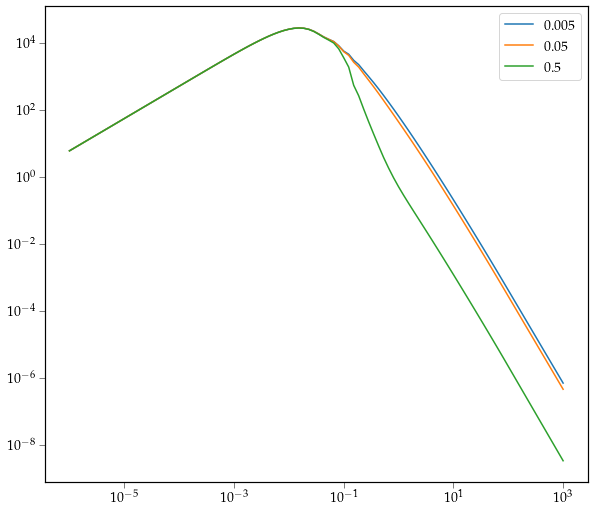

In [76]:
k_vals = np.logspace(-6, 3, 100)
plt.loglog(k_vals, lin_power[0](k_vals),label='0.005')
plt.loglog(k_vals, lin_power[1](k_vals),label='0.05')
plt.loglog(k_vals, lin_power[2](k_vals),label='0.5')
plt.legend()

#### `growth` plot

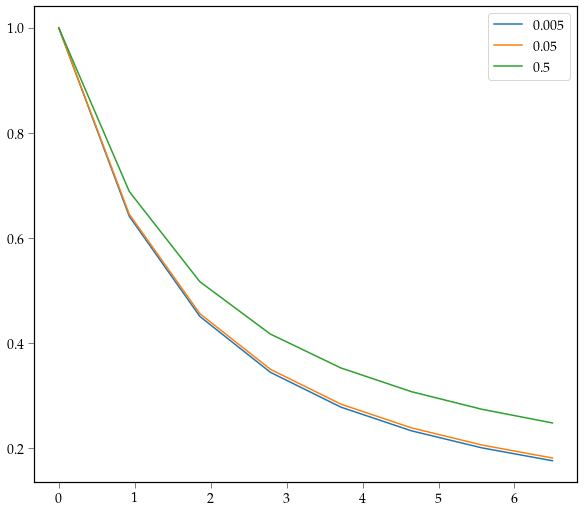

In [77]:
z_vals=np.linspace(0, 6.5, 8)
plt.plot(z_vals, growth[0](1e0, z_vals),label='0.005')
plt.plot(z_vals, growth[1](1e0, z_vals),label='0.05')
plt.plot(z_vals, growth[2](1e0, z_vals),label='0.5')
plt.legend()

#### $\sigma$ plot as a function of mass

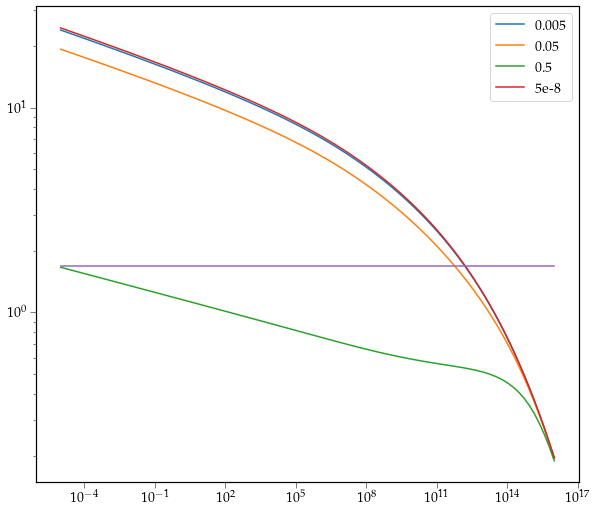

In [78]:
m_vals = np.logspace(-5, 16, 100)
plt.loglog(m_vals, sigmaIntFFT[0](m_vals, 0.0),label='0.005')
plt.loglog(m_vals, sigmaIntFFT[1](m_vals, 0.0),label='0.05')
plt.loglog(m_vals, sigmaIntFFT[2](m_vals,0.0),label='0.5')
plt.loglog(m_vals, sigmaIntFFT[3](m_vals,0.0),label='5e-8')
plt.loglog(m_vals,1.68*np.ones(len(m_vals)))
plt.legend()

#### Bubble mass function

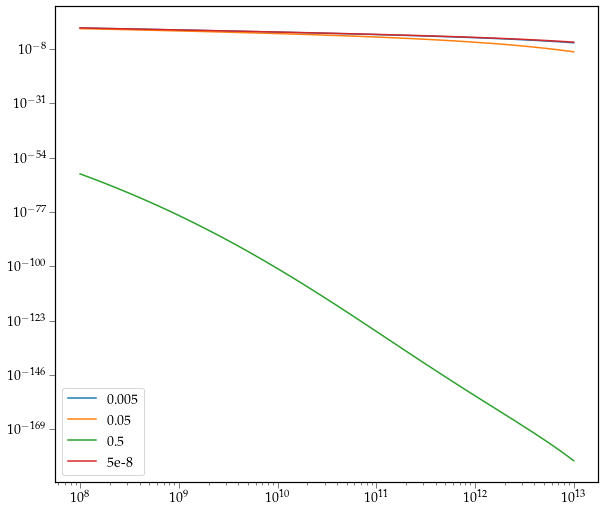

In [79]:
m_vals = np.logspace(8, 13, 100)
z = 12
plt.loglog(m_vals, bubbleFuncFFT[0](m_vals,z),label='0.005')
plt.loglog(m_vals, bubbleFuncFFT[1](m_vals,z),label='0.05')
plt.loglog(m_vals, bubbleFuncFFT[2](m_vals,z),label='0.5')
plt.loglog(m_vals, bubbleFuncFFT[3](m_vals,z),label='5e-8')
plt.legend()

#### Press-Schechter mass function

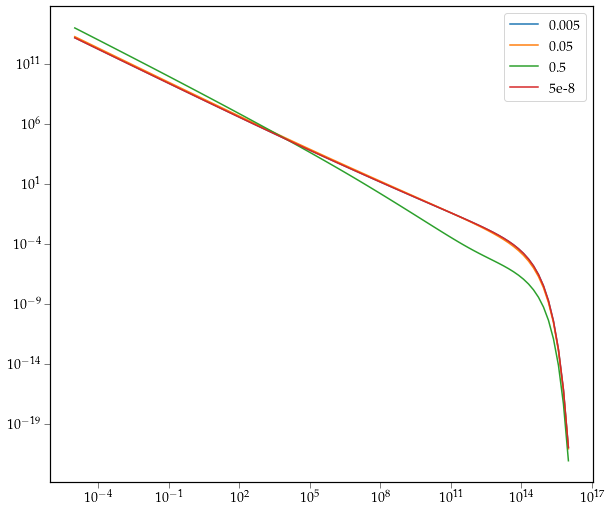

In [80]:
m_vals = np.logspace(-5,16,100)
z = 0
plt.loglog(m_vals,pressSchechterFFT[0](m_vals,z),label='0.005')
plt.loglog(m_vals,pressSchechterFFT[1](m_vals,z),label='0.05')
plt.loglog(m_vals,pressSchechterFFT[2](m_vals,z),label='0.5')
plt.loglog(m_vals,pressSchechterFFT[3](m_vals,z),label='5e-8')
plt.legend()

## Furlanetto Figure 2: Bubble distribution 

##### Function definitions to convert mass to/from radius 

In [82]:
def m_from_R(R,cosmo,h_adjust=False):
    rho = cosmo.rho_mean
    
    # Determining omega & h adjustments
    if h_adjust == True:
        rho /= cosmo.h**2

    return (4/3) * np.pi * R**3 * rho * (1+z)**3



def R_from_m(m,cosmo,h_adjust=False): 
    rho = cosmo.rho_mean
    
    # Determining omega & h adjustments
    if h_adjust == True:
        rho /= cosmo.h**2

    return (3*m/(4*np.pi*rho))**(1/3)

##### Plotting distrubtion
Distribution is $\overline{Q}^{-1}V\frac{\text{d}n}{\text{d}\ln R}$, but $\overline{Q}$ isn't working right.

Q = 1.3337438149017967e-10
Q = 7.704013332722145e-11
Q = 8.620501887259225e-67
Q = 1.3688205705884551e-10
Q = 2.8709019155050414e-11
Q = 6.78081283375556e-12
Q = 5.0674396503534505e-96
Q = 3.238873295172352e-11
Q = 9.79384432963735e-12
Q = 1.4786788899968458e-12
Q = 1.3690398883571012e-111
Q = 1.1542976651000236e-11


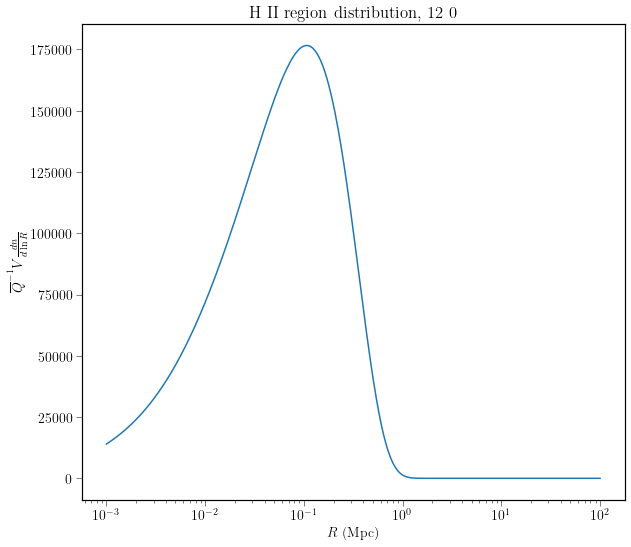

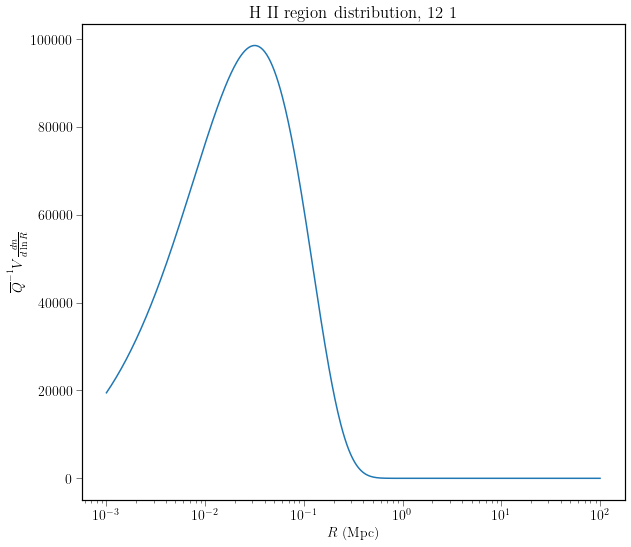

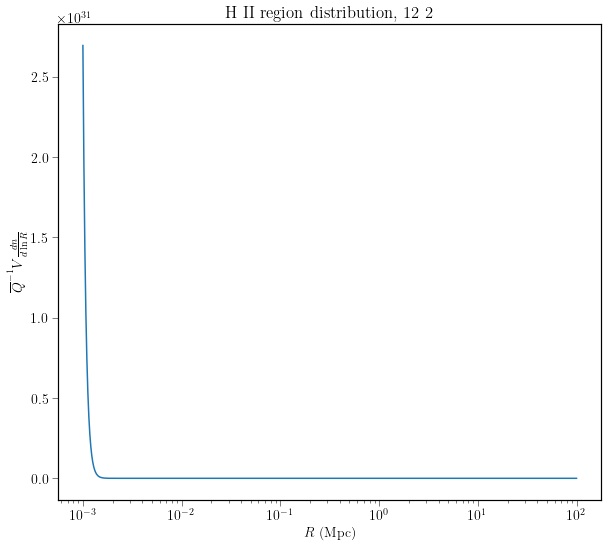

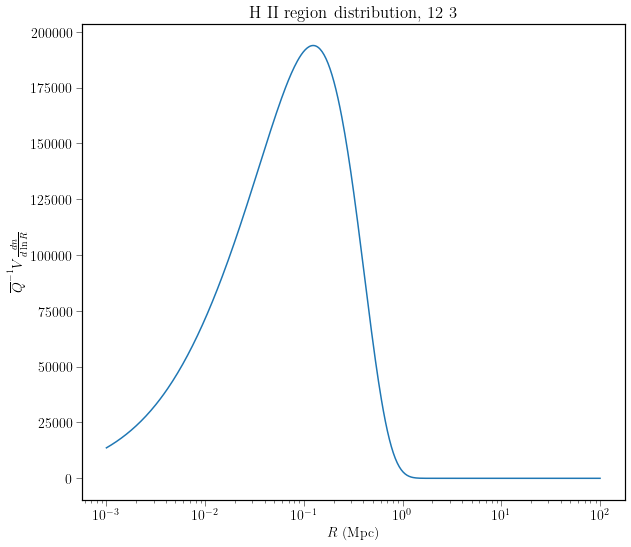

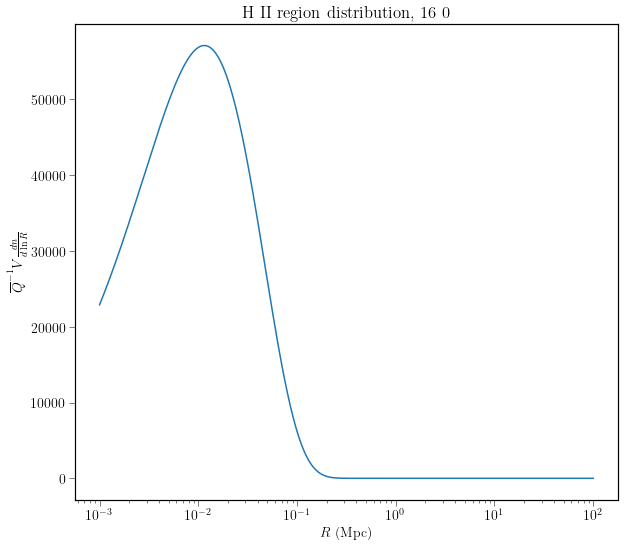

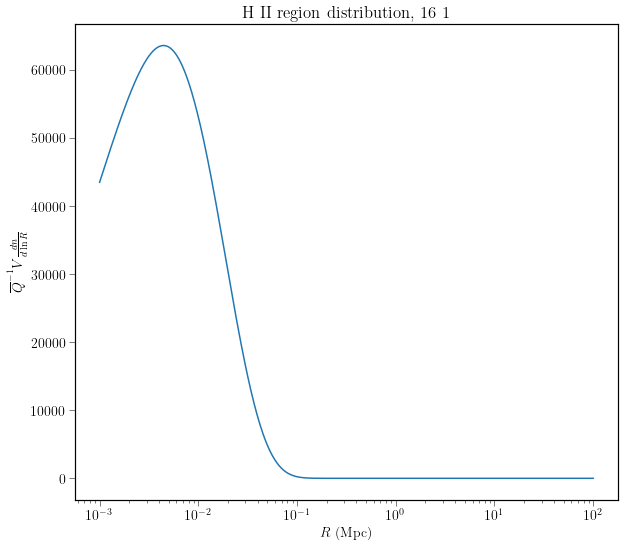

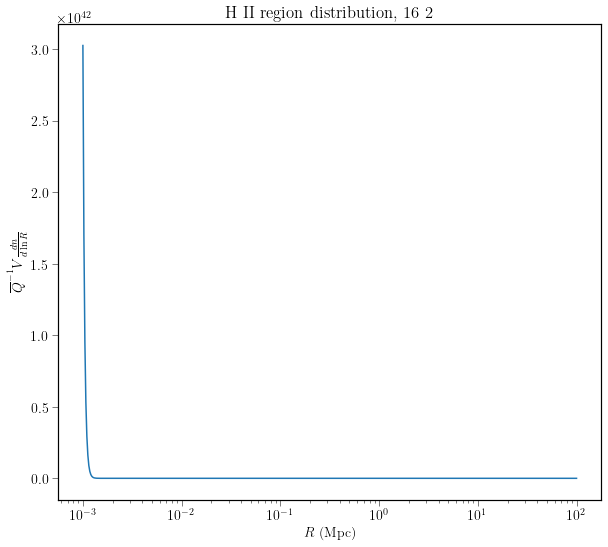

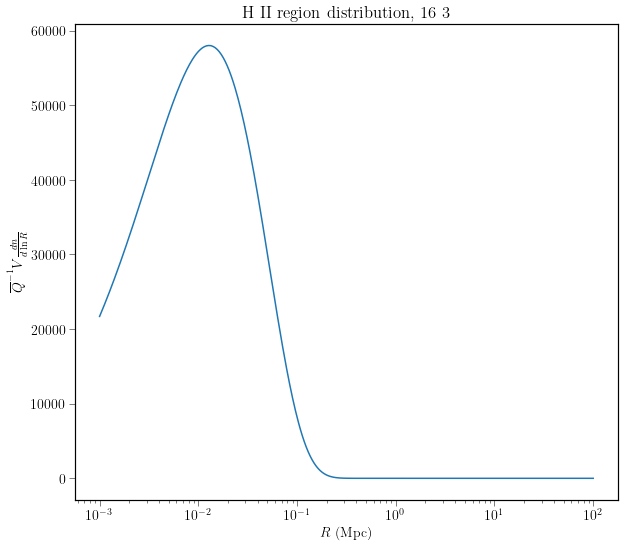

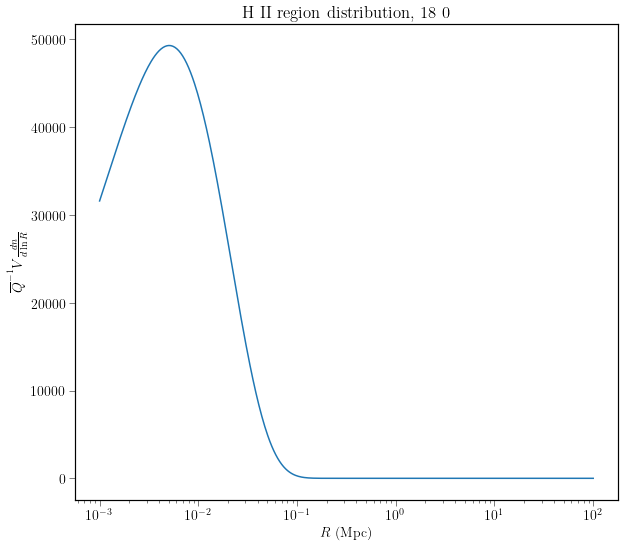

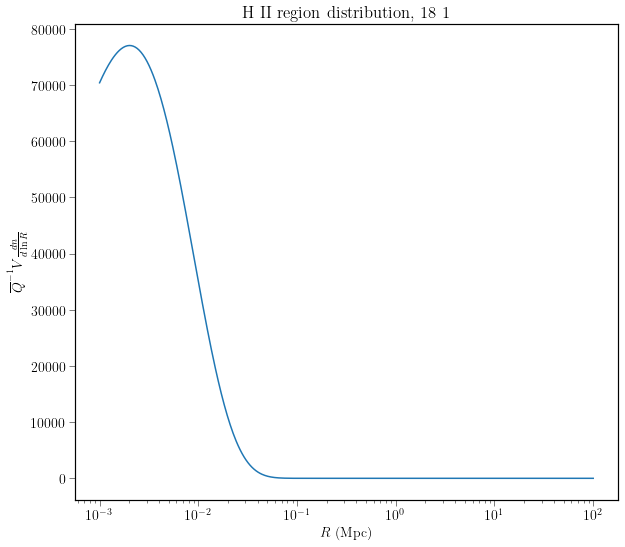

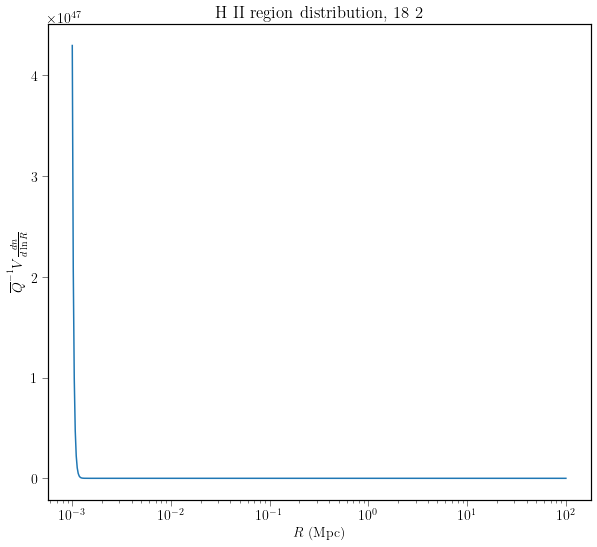

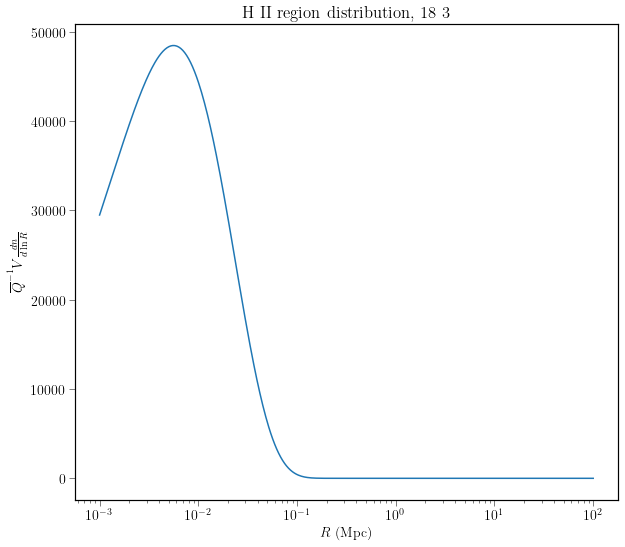

In [18]:
z_vals = [12,16,18]
zeta = 40

plt.rc('text',usetex=True)
plt.rc('font', **{'family':'serif','serif':['Times New Roman']})

for z in z_vals:
    for i in range(len(cosmos)):
        mMin = (1.308695e-10) * ((cosmos[i].RHO_C*1000 * cosmos[i].OmegaM)**(-1/2)) * ((1+z)**(-3/2)) * (1e4)**(3/2) # Included Delta in pre-eval w/ cosmology.py OmegaM property and in solar masses
#         mMin = (3.95284708e8/cosmos[i].h) * (1/(1+z))**(3/2)
        rho = cosmos[i].rho_mean * (1+z)**3
        integrand = lambda m: (1/rho) * bubbleFuncFFT[i](m,z)
        Q = quad(integrand,mMin,np.inf)[0]
        
        R_vals = np.logspace(-3,2,500)
        m_vals = (1/zeta)*m_from_R(R_vals,cosmos[i])
      
#         m_vals = np.logspace(np.log10(mMin),20,500)
#         R_vals = R_from_m(m_vals,cosmos[i])
        
        print("Q =",Q)
        title1 = f'H II region distribution, {z} {i}'

        plt.figure()
        plt.plot(R_vals,3*(1/Q)*(m_vals/rho)*bubbleFuncFFT[i](m_vals,z))
#         plt.axvline(R_from_m(zeta*mMin,cosmos[i],z),c='black',linestyle='dashed')
        plt.xscale('log')
        plt.title(title1)
        plt.xlabel(r"$R$ (Mpc)")
        plt.ylabel(r"$\overline Q^{-1}V\frac{dn}{d\ln R}$")
        savename = f'QR_{i}_{z}.pdf'
        plt.savefig(savename)

## Testing integration methods

Want to get a stable method for determining $\overline{Q}$ that hopefully doesn't throw out a bunch of warnings.

In [57]:
window = 'sharp_k'
for cid, cosmo in enumerate(cosmos):
    sigmaIntFFT[cid] = SigmaInterpolatorFFTLog(cosmo, lin_power[cid], growth[cid], z_vals_sigma, 1e-4, 1e3, Nr=1024, window_function=window)
    sigmaIntFFT[cid].compute()

/home/emelnick/anaconda3/lib/python3.9/site-packages/mcfit/mcfit.py:126: UserWarning: The default value of lowring has been changed to False, set it to True if you cannot reproduce previous results
  warnings.warn("The default value of lowring has been changed to False, "


#### A bunch of $Q$ integration methods

In [88]:
z_vals = [0,9,12,16,18]
zeta = 40

plt.rc('text',usetex=True)
plt.rc('font', **{'family':'serif','serif':['Times New Roman']})

for z in z_vals:
    
    print(f"REDSHIFT z = {z}\n")
    for i,cosmo in enumerate(cosmos):
        print(f"COSMOLOGY {i}\n")
        print(f"Axion frac = {cosmo.axion_frac}")
        mMin = (1.308695e-10) * ((cosmo.RHO_C*1000 * cosmo.OmegaM)**(-1/2)) * ((1+z)**(-3/2)) * (1e4)**(3/2) # Included Delta in pre-eval w/ cosmology.py OmegaM property and in solar masses
    #         mMin = (3.95284708e8/cosmo.h) * (1/(1+z))**(3/2)
    #         mMin = 1e1

        mMin *= 1e-8

        rho = cosmo.rho_mean * (1+z)**3
        print(f"rho = {rho}\n")

        integrand = lambda m: (1/rho) * pressSchechterFFT[i](m,z) # dn/dlogm = m dn/dm
        integrand_log = lambda m: (np.exp(m)/rho) * pressSchechterFFT[i](np.exp(m),z)

        # integrand = lambda m: (1/rho) * bubbleFuncFFT[i](m,z)
        # integrand_log = lambda m: (1/rho) * bubbleFuncFFT[i](10**m,z)

        # integrand = lambda m: (1/rho) * bmf2[i](m,z)
        # integrand_log = lambda m: (1/rho) * bmf2[i](10**m,z)


    #         R_vals = np.logspace(-3,2,500)
    #         m_vals = m_from_R(R_vals,cosmos[i])

        m_vals = np.logspace(1,20,1000)
        m_vals_log = np.linspace(1,20,1000)
        R_vals = R_from_m(m_vals,cosmos[i])


        print("Function-object integration:")
        # Quad
        Q_quad = quad(integrand,mMin,1.e20)[0]
        Q_quad_log = quad(integrand_log,np.log(mMin),np.log(1.e20))[0]     
        print(f"QUAD:\nQ = {Q_quad}\nQ_log = {Q_quad_log}\n")

        # Romberg
        Q_rmbg = romberg(integrand,mMin,1e20)
        Q_rmbg_log = romberg(integrand_log,np.log(mMin),np.log(1e20))
        print(f"ROMBERG:\nQ = {Q_rmbg}\nQ_log = {Q_rmbg_log}\n") 

        # Fixed quad
        Q_fixq = fixed_quad(integrand,mMin,1e20)[0] 
        Q_fixq_log = fixed_quad(integrand_log,np.log(mMin),np.log(1e20))[0]
        print(f"FIXED QUAD:\nQ = {Q_fixq}\nQ_log = {Q_fixq_log}\n")

        # Quadrature
        Q_qdtr = quadrature(integrand,mMin,1e20)[0]
        Q_qdtr_log = quadrature(integrand_log,np.log(mMin),np.log(1e20))[0]
        print(f"QUADRATURE:\nQ = {Q_qdtr}\nQ_log = {Q_qdtr_log}\n") 
        
        
        print("\nFixed-sample integration:\n")
        # Trapezoid
        Q_trap = trapezoid((1/rho) * pressSchechterFFT[i](m_vals,z),m_vals) 
        Q_trap_log = trapezoid((1/rho)*pressSchechterFFT[i](m_vals_log,z),m_vals_log)
        print(f"TRAPEZOID:\nQ = {Q_trap}\nQ_log = {Q_trap_log}\n") 

        # Cumulative trapezoid
        Q_ctrp = cumulative_trapezoid((1/rho) * pressSchechterFFT[i](m_vals,z),m_vals)[-1]
        Q_ctrp_log = cumulative_trapezoid((1/rho) * pressSchechterFFT[i](m_vals_log,z),m_vals_log)[-1]
        print(f"CUMULATIVE TRAPEZOID:\nQ = {Q_ctrp}\nQ_log = {Q_ctrp_log}\n") 

        # Simpson
        Q_simp = simpson((1/rho) * pressSchechterFFT[i](m_vals,z),m_vals) 
        Q_simp_log = simpson((1/rho) * pressSchechterFFT[i](m_vals_log,z),m_vals_log)
        print(f"SIMPSON:\nQ = {Q_simp}\nQ_log = {Q_simp_log}\n") 

    print("#####################################################")


REDSHIFT z = 0

COSMOLOGY 0

Axion frac = 0.005000000000000001
rho = 75388498306.23651

Function-object integration:
QUAD:
Q = 2.841164442211517e-106
Q_log = 0.8961538072687827

ROMBERG:
Q = 7782807497387.251
Q_log = 0.8961538071239988

FIXED QUAD:
Q = 0.0
Q_log = 0.73897479958705

QUADRATURE:
Q = 0.0
Q_log = 0.8961551579399685

-------------------

Fixed-sample integration:

TRAPEZOID:
Q = 0.8992935825364851
Q_log = 0.013197707409283405

CUMULATIVE TRAPEZOID:
Q = 0.8992935825364854
Q_log = 0.013197707409283391

SIMPSON:
Q = 0.8990033943567277
Q_log = 0.01319759541250928

COSMOLOGY 1

Axion frac = 0.05000000000000002
rho = 75388498306.23651

Function-object integration:
QUAD:
Q = 2.180379770350077e-106
Q_log = 0.8722322472649857

ROMBERG:
Q = 9445173398068.79
Q_log = 0.8722322470751134

FIXED QUAD:
Q = 0.0
Q_log = 0.794662094993951

QUADRATURE:
Q = 0.0
Q_log = 0.8722328637601215

-------------------

Fixed-sample integration:

TRAPEZOID:
Q = 0.8759747459822809
Q_log = 0.016034959544547

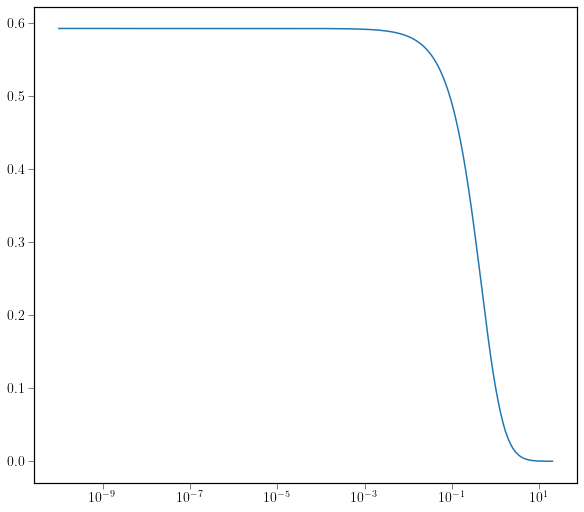

0.5928085605139104


In [123]:
z_vals = np.logspace(-10,1+np.log10(2),200)
zeta = 40

plt.rc('text',usetex=True)
plt.rc('font', **{'family':'serif','serif':['Times New Roman']})

Q = []

for z in z_vals:
    i=3
    mMin = (1.308695e-10) * ((cosmos[i].RHO_C*1000 * cosmos[i].OmegaM)**(-1/2)) * ((1+z)**(-3/2)) * (1e4)**(3/2) # Included Delta in pre-eval w/ cosmology.py OmegaM property and in solar masses
#         mMin = (3.95284708e8/cosmos[i].h) * (1/(1+z))**(3/2)
#         mMin = 1e1

    mMin *= 1e-8

    rho = cosmos[i].rho_mean * (1+z)**3

    integrand = lambda m: (1/rho) * pressSchechterFFT[i](m,z) # dn/dlogm = m dn/dm
    integrand_log = lambda m: (np.exp(m)/rho) * pressSchechterFFT[i](np.exp(m),z)

    # integrand = lambda m: (1/rho) * bubbleFuncFFT[i](m,z)
    # integrand_log = lambda m: (1/rho) * bubbleFuncFFT[i](10**m,z)

    # integrand = lambda m: (1/rho) * bmf2[i](m,z)
    # integrand_log = lambda m: (1/rho) * bmf2[i](10**m,z)


#         R_vals = np.logspace(-3,2,500)
#         m_vals = m_from_R(R_vals,cosmos[i])

    m_vals = np.logspace(1,20,1000)
    m_vals_log = np.linspace(1,20,1000)
    R_vals = R_from_m(m_vals,cosmos[i])


#     print("Function-object integration:")
#     # Quad
#     # Q_quad = quad(integrand,mMin,1.e20)[0]
    Q_quad_log = quad(integrand_log,np.log(mMin),np.log(1.e30))[0]     
#     print(f"QUAD:\nQ = {Q_quad}\nQ_log = {Q_quad_log}\n")

#     # Romberg
#     # Q_rmbg = romberg(integrand,mMin,1e20)
#     Q_rmbg_log = romberg(integrand_log,np.log(mMin),np.log(1e20))
#     print(f"ROMBERG:\nQ = {Q_rmbg}\nQ_log = {Q_rmbg_log}\n") 

#     # Fixed quad
#     # Q_fixq = fixed_quad(integrand,mMin,1e20)[0] 
#     Q_fixq_log = fixed_quad(integrand_log,np.log(mMin),np.log(1e20))[0]
#     print(f"FIXED QUAD:\nQ = {Q_fixq}\nQ_log = {Q_fixq_log}\n")

#     # Quadrature
#     # Q_qdtr = quadrature(integrand,mMin,1e20)[0]
#     Q_qdtr_log = quadrature(integrand_log,np.log(mMin),np.log(1e20))[0]
#     print(f"QUADRATURE:\nQ = {Q_qdtr}\nQ_log = {Q_qdtr_log}\n") 


#     print("Fixed-sample integration:")
#     # Trapezoid
#     # Q_trap = trapezoid((1/rho) * pressSchechterFFT[i](m_vals,z),m_vals) 
#     Q_trap_log = trapezoid((1/rho)*pressSchechterFFT[i](m_vals_log,z),m_vals_log)
#     print(f"TRAPEZOID:\nQ = {Q_trap}\nQ_log = {Q_trap_log}\n") 

#     # Cumulative trapezoid
#     # Q_ctrp = cumulative_trapezoid((1/rho) * pressSchechterFFT[i](m_vals,z),m_vals)[-1]
#     Q_ctrp_log = cumulative_trapezoid((1/rho) * pressSchechterFFT[i](m_vals_log,z),m_vals_log)[-1]
#     print(f"CUMULATIVE TRAPEZOID:\nQ = {Q_ctrp}\nQ_log = {Q_ctrp_log}\n") 

#     # Simpson
#     # Q_simp = simpson((1/rho) * pressSchechterFFT[i](m_vals,z),m_vals) 
    # Q_simp_log = simpson((1/rho) * pressSchechterFFT[i](m_vals_log,z),m_vals_log)
    
    Q.append(Q_quad_log)

plt.plot(z_vals,1-np.exp(-np.array(Q)))
plt.xscale('log')
plt.show()
print((1-np.exp(-np.array(Q)))[0])

## PS mass function plot

In [ ]:
# z_vals = [0,12,16,18]
z_vals = np.linspace(0,20,101)
# z_vals = [0]
zeta = 40
i=3
Q_vals = []
for z in z_vals:
    mMin = 1e1
    rho = cosmos[i].rho_mean * (1+z)**3
    
    if (10*z)%15 == 0:
            m_valslin = np.linspace(1,16,100)
            m_valslog = np.logspace(1,16,100)
            
            plt.figure(0)
            plt.plot(m_valslin,bubbleFuncFFT[i](10**m_valslin,z),label=z)
            plt.figure(1)
            plt.loglog(m_valslog,bubbleFuncFFT[i](m_valslog,z),label=z)
            
plt.figure(0)
plt.yscale('log')
plt.ylim([1e-16,1e7])
plt.legend()

plt.figure(1)
plt.ylim([1e-16,1e7])
plt.legend()

While the plots are generally looking like the right shape, the $Q$ values are *really* small, which would suggest that the space being considered is barely ionized at all. Furlanetto was getting values between 0.01 and 1. If I had to guess, perhaps the issue is either with how $m_{\text{min}}$ is calculated or the bubble function $m\frac{\text{d}n}{\text{d}m}$. Maybe changing the barrier from $\delta_c(z),\sigma(m)$ to $\delta_c,\sigma(m,z)$ doesn't work as nicely as I thought.

I also have noticed that Furlanetto uses Lagrangian coordinates, which other sources have talked about a bit, but I haven't been able to wrap my head around what that means or the implications of it. Is it something to be concerned about?

doi:10.1093/mnras/stw1542 (Q integral from $r_\text{min}$to $\infty$)

doi.org/10.48550/arXiv.1401.7994 (A bit on Euler/Lagrange coordinates, among other things)

doi:10.1093/mnras/stw1060

https://ned.ipac.caltech.edu/level5/Sept15/Johnson/Johnson1.html virial stuff

# 3. Testing, Scratch, and Junk<a name="test"></a>

In [ ]:
z = np.array([0,6,12,20])
mMin = (1.308695e-10) * ((cosmos[i].RHO_C*1000 * cosmos[i].OmegaM)**(-1/2)) * ((1+z)**(-3/2)) * (1e4)**(3/2) # Included Delta in pre-eval w/ cosmology.py OmegaM property and in solar masses
print(np.log10(mMin))
mMin = (3.95284708e8/cosmos[i].h) * (1/(1+z))**(3/2)
print(np.log10(mMin))


In [ ]:
T = 1e4
m_min1 = (1e8/cosmo0.h) * (10/(1+z) * T/(4e4))**(3/2)
print(m_min1)
print(np.log10(m_min1))

In [ ]:
z = 12
m_vals = np.logspace(9,15,100)
s2_vals0 = sigmaInt[0](m_vals,z)**2
s2_vals1 = sigmaInt[1](m_vals,z)**2
s2_vals2 = sigmaInt[2](m_vals,z)**2

plt.plot(s2_vals0,bubbleFunc[0].B(m_vals,z),label='h=0.005')
plt.plot(s2_vals1,bubbleFunc[1].B(m_vals,z),label='h=0.05')
plt.plot(s2_vals2,bubbleFunc[2].B(m_vals,z),label='h=0.5')
plt.legend()

a = bubbleFunc[0](m_vals,z)
a = bubbleFunc[1](m_vals,z)
a = bubbleFunc[2](m_vals,z)

In [ ]:
bmf2 = []
for i, cosmo in enumerate(cosmos):
    bmf2.append(BMF2(cosmo,sigmaIntFFT[i]))